# Q1.PREDICT THE BURNED AREA OF FOREST FIRES WITH NEURAL NETWORKS

# Required Libraries

In [1]:
#load the libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
import tensorflow as tf
tf.debugging.set_log_device_placement(False) 
import warnings
warnings.filterwarnings('ignore')

# Load Dataset And EDA

In [2]:
raw_data = pd.read_csv("forestfires.csv")
raw_data.head()

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category
0,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,0,0,0,0,1,0,0,0,0,small
1,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,0,0,0,0,0,0,0,1,0,small
2,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,0,0,0,0,0,0,0,1,0,small
3,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,...,0,0,0,0,1,0,0,0,0,small
4,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,...,0,0,0,0,1,0,0,0,0,small


In [3]:
df = raw_data.copy() #Removing the dummies at this time
df.drop(df.columns[11:30],axis=1,inplace = True)

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
FFMC,517.0,90.644681,5.520111,18.7,90.2,91.60,92.90,96.20
DMC,517.0,110.872340,64.046482,1.1,68.6,108.30,142.40,291.30
DC,517.0,547.940039,248.066192,7.9,437.7,664.20,713.90,860.60
ISI,517.0,9.021663,4.559477,0.0,6.5,8.40,10.80,56.10
temp,517.0,18.889168,5.806625,2.2,15.5,19.30,22.80,33.30
RH,517.0,44.288201,16.317469,15.0,33.0,42.00,53.00,100.00
wind,517.0,4.017602,1.791653,0.4,2.7,4.00,4.90,9.40
rain,517.0,0.021663,0.295959,0.0,0.0,0.00,0.00,6.40
area,517.0,12.847292,63.655818,0.0,0.0,0.52,6.57,1090.84


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   month          517 non-null    object 
 1   day            517 non-null    object 
 2   FFMC           517 non-null    float64
 3   DMC            517 non-null    float64
 4   DC             517 non-null    float64
 5   ISI            517 non-null    float64
 6   temp           517 non-null    float64
 7   RH             517 non-null    int64  
 8   wind           517 non-null    float64
 9   rain           517 non-null    float64
 10  area           517 non-null    float64
 11  size_category  517 non-null    object 
dtypes: float64(8), int64(1), object(3)
memory usage: 48.6+ KB


In [6]:
df.shape

(517, 12)

In [7]:
df.isnull().sum()

month            0
day              0
FFMC             0
DMC              0
DC               0
ISI              0
temp             0
RH               0
wind             0
rain             0
area             0
size_category    0
dtype: int64

<AxesSubplot:>

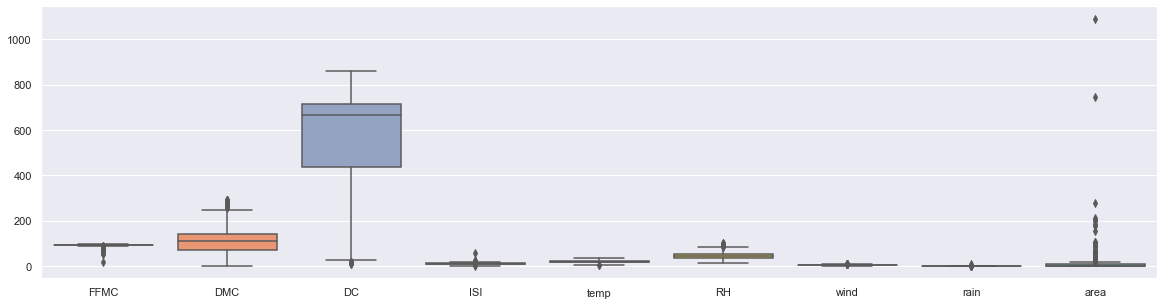

In [8]:
sns.set(rc={'figure.figsize':(20,5)})
sns.boxplot(data=df, orient="v", palette="Set2") 
#There are outliers in the case of area. But we cannot discard it

# Feature Analysis

In [9]:
df.month.value_counts()

aug    184
sep    172
mar     54
jul     32
feb     20
jun     17
oct     15
apr      9
dec      9
jan      2
may      2
nov      1
Name: month, dtype: int64

In [10]:
df.size_category.value_counts() # The dataset is biased. Lets remove the bias.

small    378
large    139
Name: size_category, dtype: int64

In [11]:
#We are going to perform label encoding since it is faster than dummy variables

from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
df.month= label_encoder.fit_transform(df.month) 
df.day= label_encoder.fit_transform(df.day) 
df.size_category= label_encoder.fit_transform(df.size_category) 
df.head()

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,size_category
0,7,0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,1
1,10,5,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,1
2,10,2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,1
3,7,0,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,1
4,7,3,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,1


# Removing Bias in the Dataset

In [16]:
#!pip install imblearn

In [17]:
from imblearn.combine import SMOTETomek
from collections import Counter

resamp = df.copy()
#SMOTEK TECHNIQUE

#Define dataset
a = resamp.iloc[:,:-1]
b = resamp.iloc[:,-1]

#Count before
print(Counter(b))

smt = SMOTETomek(sampling_strategy = 'auto')
a, b = smt.fit_resample(a, b)

#Count after
print(Counter(b)) #removed bias in dataset

Counter({1: 378, 0: 139})
Counter({1: 370, 0: 370})


# Train | Split dataset

In [18]:
X = a
Y = b
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.3)

# Visualizing the data

Text(0.5, 1.0, 'T-Sine Visualization of forest-fire dataset')

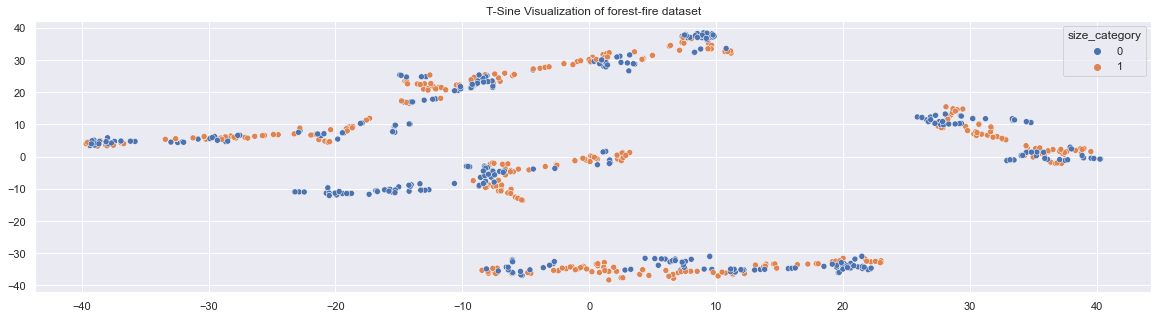

In [21]:
#Visualising the data via dimensionality reduction t-Sine Technique
from sklearn.manifold import TSNE

data_tsne_pca = TSNE(n_components=2).fit_transform(a)
sns.scatterplot(data_tsne_pca[:,0],data_tsne_pca[:,1],hue=b, palette="deep").set_title('T-Sine Visualization of forest-fire dataset')

# Neural Network

In [22]:
import keras 
from keras.models import Sequential
from keras.layers import Dense

In [23]:
# create model
model1 = Sequential()
model1.add(Dense(14, input_dim=11, kernel_initializer='uniform', activation='relu'))
model1.add(Dense(12,kernel_initializer='uniform', activation='relu'))
model1.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
# Compile model
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
hist1 = model1.fit(X_train, y_train, validation_split=0.33, epochs=30, batch_size=10)
#At epoch 25 itself our model reaches accuracy of 98% which maybe overfitting

Epoch 1/30
35/35 [==============================] - 2s 16ms/step - loss: 0.6896 - accuracy: 0.5476 - val_loss: 0.6857 - val_accuracy: 0.4912
Epoch 2/30
35/35 [==============================] - 0s 4ms/step - loss: 0.6757 - accuracy: 0.5648 - val_loss: 0.6569 - val_accuracy: 0.7310
Epoch 3/30
35/35 [==============================] - 0s 4ms/step - loss: 0.6345 - accuracy: 0.6513 - val_loss: 0.6330 - val_accuracy: 0.4912
Epoch 4/30
35/35 [==============================] - 0s 4ms/step - loss: 0.6202 - accuracy: 0.6369 - val_loss: 0.5284 - val_accuracy: 0.7778
Epoch 5/30
35/35 [==============================] - 0s 4ms/step - loss: 0.5374 - accuracy: 0.7262 - val_loss: 0.4598 - val_accuracy: 0.9298
Epoch 6/30
35/35 [==============================] - 0s 4ms/step - loss: 0.4448 - accuracy: 0.8847 - val_loss: 0.3840 - val_accuracy: 0.9883
Epoch 7/30
35/35 [==============================] - 0s 4ms/step - loss: 0.3794 - accuracy: 0.8646 - val_loss: 0.2782 - val_accuracy: 0.8772
Epoch 8/30
35/35 [=

# Model Evaluation

In [24]:
test_loss, test_acc = model1.evaluate(X_test, y_test)

7/7 [==============================] - 0s 3ms/step - loss: 0.0358 - accuracy: 0.9910


In [25]:
print(hist1.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [26]:
hist1_df = pd.DataFrame(hist1.history)
hist1_df["epoch"]=hist1.epoch
hist1_df.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
25,0.127784,0.945245,0.123003,0.953216,25
26,0.245438,0.899135,0.035953,0.988304,26
27,0.161377,0.942363,0.053046,0.976608,27
28,0.054409,0.974063,0.047198,0.976608,28
29,0.035924,0.994236,0.048117,0.976608,29


# Visualize Training History

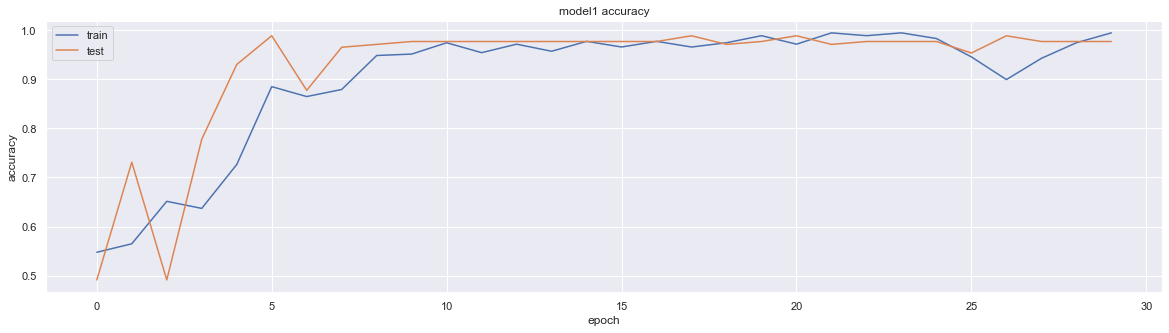

In [27]:
# summarize history for accuracy
plt.plot(hist1.history['accuracy'])
plt.plot(hist1.history['val_accuracy'])
plt.title('model1 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

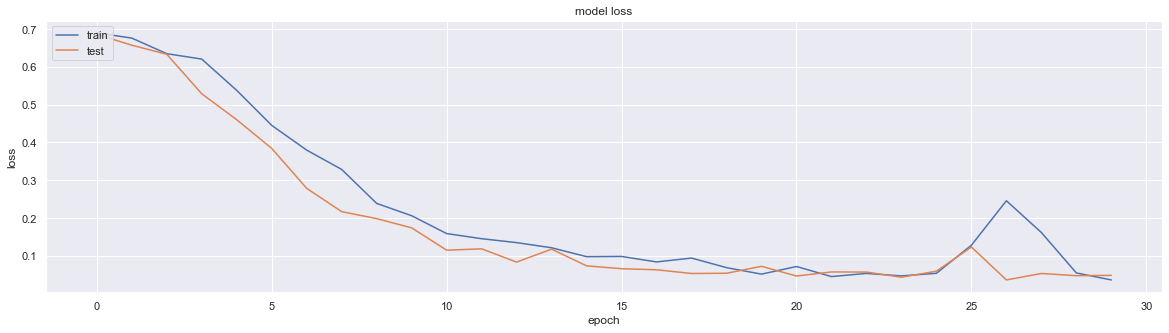

In [28]:
# summarize history for loss
plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show() #Loss decreases and starts oscillating after 25

# Tuning HyperParameters

In [29]:
from sklearn.preprocessing import StandardScaler
a = StandardScaler()
a.fit(X)
X_standardized = a.transform(X)



from tensorflow import keras
from keras.layers import Conv2D, Input, MaxPool2D,Flatten, Dense, Permute, GlobalAveragePooling2D
from keras.models import Model
from tensorflow.keras.optimizers import Adam
# Importing the necessary packages
from sklearn.model_selection import GridSearchCV, KFold
from keras.wrappers.scikit_learn import KerasClassifier

# 1 : Batch Size and Epochs

In [30]:
# create model function
def create_model():
    model = Sequential()
    model.add(Dense(14, input_dim=11, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(12, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
    
    adam=Adam(lr=0.01) #learning rate = 0.01
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

In [31]:
# Create the model
model = KerasClassifier(build_fn = create_model,verbose = 0)
# Define the grid search parameters
batch_size = [10,20,40]
epochs = [10,25,50,100]
# Make a dictionary of the grid search parameters
param_grid = dict(batch_size = batch_size,epochs = epochs)
# Build and fit the GridSearchCV
grid = GridSearchCV(estimator = model,param_grid = param_grid,cv = KFold(),verbose = 10)
grid_result = grid.fit(X_standardized,Y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START batch_size=10, epochs=10...................................
[CV 1/5; 1/12] END ....batch_size=10, epochs=10;, score=0.993 total time=   2.8s
[CV 2/5; 1/12] START batch_size=10, epochs=10...................................
[CV 2/5; 1/12] END ....batch_size=10, epochs=10;, score=0.953 total time=   2.9s
[CV 3/5; 1/12] START batch_size=10, epochs=10...................................
[CV 3/5; 1/12] END ....batch_size=10, epochs=10;, score=0.919 total time=   2.7s
[CV 4/5; 1/12] START batch_size=10, epochs=10...................................
[CV 4/5; 1/12] END ....batch_size=10, epochs=10;, score=0.973 total time=   2.6s
[CV 5/5; 1/12] START batch_size=10, epochs=10...................................
[CV 5/5; 1/12] END ....batch_size=10, epochs=10;, score=0.966 total time=   3.0s
[CV 1/5; 2/12] START batch_size=10, epochs=25...................................
[CV 1/5; 2/12] END ....batch_size=10, epochs=25;

In [32]:
# Summarize the results
print('Best : {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print('{},{} with: {}'.format(mean, stdev, param))
#According to this, the best batch size is 20 and epochs is 50

Best : 0.9797297239303588, using {'batch_size': 20, 'epochs': 100}
0.9608108043670655,0.024696845463729508 with: {'batch_size': 10, 'epochs': 10}
0.9729729771614075,0.021366735750974725 with: {'batch_size': 10, 'epochs': 25}
0.9783783674240112,0.021108776431317432 with: {'batch_size': 10, 'epochs': 50}
0.9797297120094299,0.01761946917239452 with: {'batch_size': 10, 'epochs': 100}
0.9675675630569458,0.03348515976952905 with: {'batch_size': 20, 'epochs': 10}
0.9635135173797608,0.020315262782961644 with: {'batch_size': 20, 'epochs': 25}
0.9756756544113159,0.021621616929771246 with: {'batch_size': 20, 'epochs': 50}
0.9797297239303588,0.021366735750974725 with: {'batch_size': 20, 'epochs': 100}
0.945945942401886,0.030815559800574703 with: {'batch_size': 40, 'epochs': 10}
0.9662162065505981,0.05074318229893609 with: {'batch_size': 40, 'epochs': 25}
0.9756756663322449,0.024399288502843234 with: {'batch_size': 40, 'epochs': 50}
0.9783783555030823,0.023561613490320175 with: {'batch_size': 40, '

# 2 : Learning Rate and Dropout Rate

In [34]:
from keras.layers import Dropout

# Defining the model

def create_model2(learning_rate,dropout_rate):
    model = Sequential()
    model.add(Dense(14,input_dim = 11,kernel_initializer = 'uniform',activation = 'relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(12,input_dim = 14,kernel_initializer = 'uniform',activation = 'relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1,kernel_initializer='uniform',activation = 'sigmoid'))
    
    adam = Adam(lr = learning_rate)
    model.compile(loss = 'binary_crossentropy',optimizer = adam,metrics = ['accuracy'])
    return model

# Create the model

model2 = KerasClassifier(build_fn = create_model2,verbose = 0,batch_size = 20,epochs = 50)

# Define the grid search parameters

learning_rate = [0.001,0.01,0.1]
dropout_rate = [0.0,0.1,0.2]

# Make a dictionary of the grid search parameters

param_grids2 = dict(learning_rate = learning_rate,dropout_rate = dropout_rate)

# Build and fit the GridSearchCV

grid2 = GridSearchCV(estimator = model2,param_grid = param_grids2,cv = KFold(),verbose = 10)
grid_result2 = grid2.fit(X_standardized,Y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START dropout_rate=0.0, learning_rate=0.001.......................
[CV 1/5; 1/9] END dropout_rate=0.0, learning_rate=0.001;, score=1.000 total time=   4.4s
[CV 2/5; 1/9] START dropout_rate=0.0, learning_rate=0.001.......................
[CV 2/5; 1/9] END dropout_rate=0.0, learning_rate=0.001;, score=1.000 total time=   4.3s
[CV 3/5; 1/9] START dropout_rate=0.0, learning_rate=0.001.......................
[CV 3/5; 1/9] END dropout_rate=0.0, learning_rate=0.001;, score=0.939 total time=   4.8s
[CV 4/5; 1/9] START dropout_rate=0.0, learning_rate=0.001.......................
[CV 4/5; 1/9] END dropout_rate=0.0, learning_rate=0.001;, score=0.986 total time=   4.4s
[CV 5/5; 1/9] START dropout_rate=0.0, learning_rate=0.001.......................
[CV 5/5; 1/9] END dropout_rate=0.0, learning_rate=0.001;, score=0.993 total time=   4.4s
[CV 1/5; 2/9] START dropout_rate=0.0, learning_rate=0.01........................
[CV 1/5; 

In [35]:
# Summarize the results
print('Best : {}, using {}'.format(grid_result2.best_score_,grid_result2.best_params_))
means2 = grid_result2.cv_results_['mean_test_score']
stds2 = grid_result2.cv_results_['std_test_score']
params2 = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means2, stds2, params2):
  print('{},{} with: {}'.format(mean, stdev, param))
#Best score for Dropout rate = 0.2 and learning rate is 0.001

Best : 0.9864864826202393, using {'dropout_rate': 0.1, 'learning_rate': 0.001}
0.9837837815284729,0.02285342057616365 with: {'dropout_rate': 0.0, 'learning_rate': 0.001}
0.9797297120094299,0.01761946917239452 with: {'dropout_rate': 0.0, 'learning_rate': 0.01}
0.9729729652404785,0.018627086129805737 with: {'dropout_rate': 0.0, 'learning_rate': 0.1}
0.9864864826202393,0.01417307841194491 with: {'dropout_rate': 0.1, 'learning_rate': 0.001}
0.9770270228385926,0.030096028125389564 with: {'dropout_rate': 0.1, 'learning_rate': 0.01}
0.9391891837120057,0.06810596623662407 with: {'dropout_rate': 0.1, 'learning_rate': 0.1}
0.9864864706993103,0.020494265392438586 with: {'dropout_rate': 0.2, 'learning_rate': 0.001}
0.9797297358512879,0.010467516318194495 with: {'dropout_rate': 0.2, 'learning_rate': 0.01}
0.8864864706993103,0.12036892948519551 with: {'dropout_rate': 0.2, 'learning_rate': 0.1}


# 3 : Activation Function and Kernel Initializer

In [36]:
# Defining the model

def create_model3(activation_function,init):
    model = Sequential()
    model.add(Dense(14,input_dim = 11,kernel_initializer = init,activation = activation_function))
    model.add(Dropout(0.2))
    model.add(Dense(12,input_dim = 14,kernel_initializer = init,activation = activation_function))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation = 'sigmoid'))
    
    adam = Adam(lr = 0.001)
    model.compile(loss = 'binary_crossentropy',optimizer = adam,metrics = ['accuracy'])
    return model

# Create the model

model3 = KerasClassifier(build_fn = create_model3,verbose = 0,batch_size = 20,epochs = 50)

# Define the grid search parameters
activation_function = ['softmax','relu','tanh','linear']
init = ['uniform','normal','zero']

# Make a dictionary of the grid search parameters
param_grids3 = dict(activation_function = activation_function,init = init)

# Build and fit the GridSearchCV

grid3 = GridSearchCV(estimator = model3,param_grid = param_grids3,cv = KFold(),verbose = 10)
grid_result3 = grid3.fit(X_standardized,Y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START activation_function=softmax, init=uniform..................
[CV 1/5; 1/12] END activation_function=softmax, init=uniform;, score=0.000 total time=   5.2s
[CV 2/5; 1/12] START activation_function=softmax, init=uniform..................
[CV 2/5; 1/12] END activation_function=softmax, init=uniform;, score=0.777 total time=   5.0s
[CV 3/5; 1/12] START activation_function=softmax, init=uniform..................
[CV 3/5; 1/12] END activation_function=softmax, init=uniform;, score=0.439 total time=   5.0s
[CV 4/5; 1/12] START activation_function=softmax, init=uniform..................
[CV 4/5; 1/12] END activation_function=softmax, init=uniform;, score=0.595 total time=   4.9s
[CV 5/5; 1/12] START activation_function=softmax, init=uniform..................
[CV 5/5; 1/12] END activation_function=softmax, init=uniform;, score=0.189 total time=   5.0s
[CV 1/5; 2/12] START activation_function=softmax, init=normal...

In [37]:
# Summarize the results
print('Best : {}, using {}'.format(grid_result3.best_score_,grid_result3.best_params_))
means3 = grid_result3.cv_results_['mean_test_score']
stds3 = grid_result3.cv_results_['std_test_score']
params3 = grid_result3.cv_results_['params']
for mean, stdev, param in zip(means3, stds3, params3):
  print('{},{} with: {}'.format(mean, stdev, param))
#best activation function in our case would be Relu and Kernel Initializer is Uniform

Best : 0.987837839126587, using {'activation_function': 'linear', 'init': 'normal'}
0.4,0.2778465089768472 with: {'activation_function': 'softmax', 'init': 'uniform'}
0.4108108222484589,0.27293952798606863 with: {'activation_function': 'softmax', 'init': 'normal'}
0.398648639023304,0.2783914899524581 with: {'activation_function': 'softmax', 'init': 'zero'}
0.9837837815284729,0.010978435471803497 with: {'activation_function': 'relu', 'init': 'uniform'}
0.983783769607544,0.015759321074451205 with: {'activation_function': 'relu', 'init': 'normal'}
0.20270270705223084,0.18295720773420496 with: {'activation_function': 'relu', 'init': 'zero'}
0.9878378272056579,0.013101840709125814 with: {'activation_function': 'tanh', 'init': 'uniform'}
0.9878378272056579,0.014428468825342008 with: {'activation_function': 'tanh', 'init': 'normal'}
0.20270270705223084,0.18295720773420496 with: {'activation_function': 'tanh', 'init': 'zero'}
0.9878378272056579,0.011624762488609932 with: {'activation_function'

# 4: Number of neurons in activation layer

In [38]:
# Defining the model

def create_model4(neuron1,neuron2):
    model = Sequential()
    model.add(Dense(neuron1,input_dim = 11,kernel_initializer = 'uniform',activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(neuron2,input_dim = neuron1,kernel_initializer = 'uniform',activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation = 'sigmoid'))
    
    adam = Adam(lr = 0.001)
    model.compile(loss = 'binary_crossentropy',optimizer = adam,metrics = ['accuracy'])
    return model

# Create the model

model4 = KerasClassifier(build_fn = create_model4,verbose = 0,batch_size = 20,epochs = 50)

# Define the grid search parameters

neuron1 = [4,8,14]
neuron2 = [4,8,12]

# Make a dictionary of the grid search parameters

param_grids4 = dict(neuron1 = neuron1,neuron2 = neuron2)

# Build and fit the GridSearchCV

grid4 = GridSearchCV(estimator = model4,param_grid = param_grids4,cv = KFold(),verbose = 10)
grid_result4 = grid4.fit(X_standardized,Y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START neuron1=4, neuron2=4........................................
[CV 1/5; 1/9] END .........neuron1=4, neuron2=4;, score=1.000 total time=   4.5s
[CV 2/5; 1/9] START neuron1=4, neuron2=4........................................
[CV 2/5; 1/9] END .........neuron1=4, neuron2=4;, score=0.953 total time=   5.2s
[CV 3/5; 1/9] START neuron1=4, neuron2=4........................................
[CV 3/5; 1/9] END .........neuron1=4, neuron2=4;, score=0.912 total time=   4.6s
[CV 4/5; 1/9] START neuron1=4, neuron2=4........................................
[CV 4/5; 1/9] END .........neuron1=4, neuron2=4;, score=0.939 total time=   4.5s
[CV 5/5; 1/9] START neuron1=4, neuron2=4........................................
[CV 5/5; 1/9] END .........neuron1=4, neuron2=4;, score=0.926 total time=   4.5s
[CV 1/5; 2/9] START neuron1=4, neuron2=8........................................
[CV 1/5; 2/9] END .........neuron1=4, neuron2=8;,

In [39]:
# Summarize the results
print('Best : {}, using {}'.format(grid_result4.best_score_,grid_result4.best_params_))
means4 = grid_result4.cv_results_['mean_test_score']
stds4 = grid_result4.cv_results_['std_test_score']
params4 = grid_result4.cv_results_['params']
for mean, stdev, param in zip(means4, stds4, params4):
  print('{},{} with: {}'.format(mean, stdev, param))

#Best results are Neuron 1 = 4 and Neuron 2 = 4

Best : 0.9864864826202393, using {'neuron1': 8, 'neuron2': 12}
0.9459459543228149,0.03021712748266583 with: {'neuron1': 4, 'neuron2': 4}
0.9824324250221252,0.01632843866501799 with: {'neuron1': 4, 'neuron2': 8}
0.9662162065505981,0.0328242005250879 with: {'neuron1': 4, 'neuron2': 12}
0.9770270228385926,0.022039869188702935 with: {'neuron1': 8, 'neuron2': 4}
0.9837837815284729,0.013913003095515606 with: {'neuron1': 8, 'neuron2': 8}
0.9864864826202393,0.01761946460092588 with: {'neuron1': 8, 'neuron2': 12}
0.9770270228385926,0.020315254853279823 with: {'neuron1': 14, 'neuron2': 4}
0.983783769607544,0.01939554654945987 with: {'neuron1': 14, 'neuron2': 8}
0.9837837815284729,0.01632843866501799 with: {'neuron1': 14, 'neuron2': 12}


# Building Final Model

In [40]:
# Defining the model

def create_model_fnl():
    model = Sequential()
    model.add(Dense(4,input_dim = 11,kernel_initializer = 'uniform',activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(4,input_dim = 4,kernel_initializer = 'uniform',activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation = 'sigmoid'))
    
    adam = Adam(lr = 0.001) #sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
    model.compile(loss = 'binary_crossentropy',optimizer = adam,metrics = ['accuracy'])
    return model

In [41]:
# Create the model
model_fnl = KerasClassifier(build_fn = create_model_fnl,verbose = 0,batch_size = 20,epochs = 50)

In [42]:
#Making training and Testing Data
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_standardized,Y, test_size = 0.3)

In [43]:
# Fitting the model
hist2 = model_fnl.fit(X_train_1,y_train_1)

In [44]:
from sklearn.metrics import confusion_matrix,classification_report,plot_confusion_matrix
def report_model(model):
    model_preds = model.predict(X_test_1)
    print(confusion_matrix(y_test_1,model_preds))
    print(classification_report(y_test_1,model_preds))
report_model(model_fnl)

7/7 [==============================] - 0s 3ms/step
[[105   9]
 [  0 108]]
              precision    recall  f1-score   support

           0       1.00      0.92      0.96       114
           1       0.92      1.00      0.96       108

    accuracy                           0.96       222
   macro avg       0.96      0.96      0.96       222
weighted avg       0.96      0.96      0.96       222

